### Hierarchical Bayesian Regression

  Solar Generation     Wind Generation     Hour      Month
        |                    |             |          |
        |                    |             |          |
        +--------------------+-------------+----------+
                                    |
                                  Demand
                                    |
                                    |
                                  Price


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
import pandas as pd
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import jax
import jax.numpy as jnp
from jax import random

# Load the data
data= pd.read_pickle('merged_df_DK2.pkl')


# Convert HourDK to datetime and extract hour and month
data['HourDK'] = pd.to_datetime(data['HourDK'])
data['Hour'] = data['HourDK'].dt.hour
data['Month'] = data['HourDK'].dt.month

# Selecting relevant variables
features = data[['Solar', 'Wind', 'Hour', 'Month']]
demand = data['GrossConsumptionMWh']
price = data['SpotPriceEUR']

# Convert to numpy arrays
features = jnp.array(features)
demand = jnp.array(demand)
price = jnp.array(price)

num_total_obs = len(data)
num_train_obs = int(0.8 * num_total_obs)
num_test_obs = num_total_obs - num_train_obs

# Define the model
def model(features, demand, num_train_obs, obs=None):
    # Priors for the demand model
    beta_demand = numpyro.sample('beta_demand', dist.Normal(0, 1).expand([4]))  # 4 features
    sigma_demand = numpyro.sample('sigma_demand', dist.Exponential(1))

    # Demand model
    demand_mu = jnp.dot(features, beta_demand)
    observed_demand = numpyro.sample('observed_demand', dist.Normal(demand_mu, sigma_demand))

    # Priors for the price model
    alpha_price = numpyro.sample('alpha_price', dist.Normal(0, 10))
    beta_price = numpyro.sample('beta_price', dist.Normal(0, 10))
    sigma_price = numpyro.sample('sigma_price', dist.Exponential(1))

    # Price model
    price_mu = alpha_price + beta_price * observed_demand
    numpyro.sample('observed_price', dist.Normal(price_mu[:num_train_obs], sigma_price), obs=obs[:num_train_obs])
    numpyro.sample('predicted_price', dist.Normal(price_mu, sigma_price), obs=None)

# Run inference
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000)
mcmc.run(random.PRNGKey(0), features, demand, num_train_obs, obs=price)

# Extract the samples
samples = mcmc.get_samples()

# Analyze the results
print(samples)


sample: 100%|██████████| 1500/1500 [16:28<00:00,  1.52it/s, 1023 steps of size 2.10e-03. acc. prob=0.94]


{'alpha_price': Array([69.76857 , 69.526924, 69.83217 , 70.3684  , 69.49033 , 69.99777 ,
       69.686295, 69.76799 , 69.506966, 69.84913 , 69.52169 , 69.57614 ,
       70.32869 , 69.5568  , 69.27135 , 69.63756 , 69.48671 , 69.467545,
       69.40953 , 70.123955, 68.959274, 68.18649 , 68.472206, 69.78034 ,
       69.77707 , 69.34635 , 70.06554 , 69.26176 , 69.34047 , 70.00449 ,
       69.02498 , 69.58674 , 69.95093 , 69.11575 , 70.27244 , 68.900955,
       69.00523 , 70.67552 , 68.347115, 68.19347 , 68.19372 , 68.352486,
       70.528305, 69.85225 , 69.06924 , 70.26897 , 70.36372 , 69.00523 ,
       69.142456, 70.33266 , 69.39736 , 69.92602 , 70.96783 , 68.81124 ,
       68.696495, 68.18618 , 70.95085 , 69.19807 , 70.272644, 70.19426 ,
       69.110306, 70.43505 , 69.3235  , 69.47611 , 68.94211 , 70.020226,
       69.58028 , 69.587944, 69.825066, 70.36131 , 69.31885 , 68.95615 ,
       70.35059 , 70.433365, 70.40915 , 70.36965 , 69.178474, 69.96728 ,
       69.974815, 69.435715, 70.749

In [21]:
mcmc.print_summary()


                            mean       std    median      5.0%     95.0%     n_eff     r_hat
           alpha_price     69.55      0.63     69.58     68.55     70.71    181.58      1.03
        beta_demand[0]     -0.00      0.00     -0.00     -0.00      0.00      2.85      2.11
        beta_demand[1]     -0.00      0.00     -0.00     -0.00      0.00      2.55      2.54
        beta_demand[2]      0.01      0.01      0.01      0.00      0.03      2.61      2.43
        beta_demand[3]      0.02      0.01      0.01     -0.00      0.04      2.67      2.35
            beta_price      5.85      5.04      4.05     -0.69     13.78      2.57      2.42
    observed_demand[0]      0.11      1.08      0.14     -1.79      1.69     45.31      1.05
    observed_demand[1]     -0.41      0.94     -0.39     -2.28      0.82      4.69      1.48
    observed_demand[2]      0.08      1.46     -0.04     -1.93      2.63     14.68      1.14
    observed_demand[3]     -0.29      1.25     -0.19     -2.01      1

In [24]:
samples["predicted_price"].shape

(1000, 18960)

In [26]:
import matplotlib.pyplot as plt

In [31]:
ix_test

range(15168, 18960)

In [32]:
num_test_obs

3792

In [33]:
18960-15168

3792

In [34]:
y_pred_mean

Array([-10.031711 ,  25.534847 , -20.569267 , ...,  -2.536287 ,
        -9.271219 ,  -4.2301946], dtype=float32)

In [44]:
num_train = 10

In [43]:
num_show = 100

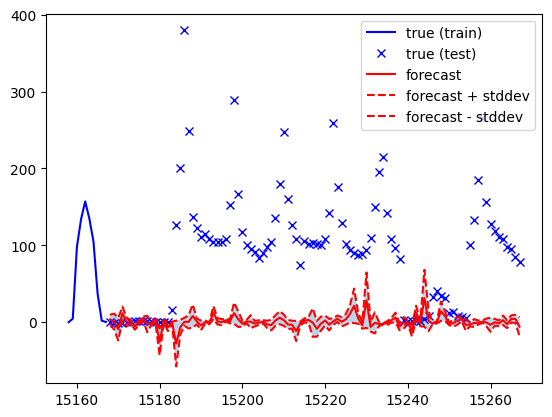

In [46]:
q = samples["predicted_price"]
q_mean = q.mean(axis=0).reshape(-1,)
q_std = q.std(axis=0).reshape(-1,)
y_pred_025 = q_mean - 1.96*q_std
y_pred_975 = q_mean + 1.96*q_std
y_pred_mean = q_mean
ix_train = range(num_train_obs-num_train ,num_train_obs)
ix_test = range(num_train_obs, num_train_obs + num_show)
plt.plot(ix_train, price[num_train_obs-num_train:num_train_obs], "b-")
plt.plot(ix_test, price[-num_test_obs:-num_test_obs + num_show], "bx")
plt.plot(ix_test, y_pred_mean[-num_test_obs:-num_test_obs + num_show], "r-")
plt.plot(ix_test, y_pred_025[-num_test_obs:-num_test_obs + num_show], "r--")
plt.plot(ix_test, y_pred_975[-num_test_obs:-num_test_obs + num_show], "r--")
plt.fill_between(ix_test, y_pred_025[-num_test_obs:-num_test_obs + num_show], y_pred_975[-num_test_obs:-num_test_obs + num_show], alpha=0.3)
plt.legend(["true (train)","true (test)","forecast","forecast + stddev","forecast - stddev"])

plt.show()

In [13]:
len(features[:num_train_obs])

15168

In [11]:
len(features)

18960

In [7]:
print( features)

[[2.2678999e-02 1.1142811e+03 0.0000000e+00 1.0000000e+00]
 [2.2142000e-02 1.2068257e+03 1.0000000e+00 1.0000000e+00]
 [2.0423001e-02 1.2156854e+03 2.0000000e+00 1.0000000e+00]
 ...
 [4.2942101e-01 1.2797307e+03 2.1000000e+01 2.0000000e+00]
 [4.3717101e-01 1.2336047e+03 2.2000000e+01 2.0000000e+00]
 [2.4183400e-01 1.1792345e+03 2.3000000e+01 2.0000000e+00]]


In [8]:
print(demand)

[1415.5178 1394.0537 1342.5934 ... 1767.7294 1654.0569 1566.9908]


In [9]:
print(num_train_obs)

15168


In [10]:
print(num_test_obs)

3792


In [ ]:
mcmc.print_summary()


                    mean       std    median      5.0%     95.0%     n_eff     r_hat
   alpha_price    130.26      4.54    130.17    122.59    137.19    880.81      1.00
beta_demand[0]      1.28      0.03      1.28      1.23      1.32    501.89      1.00
beta_demand[1]      0.78      0.01      0.78      0.77      0.79    612.01      1.00
beta_demand[2]     44.46      0.41     44.48     43.79     45.10    444.60      1.00
beta_demand[3]     42.66      0.65     42.69     41.55     43.69    594.93      1.00
    beta_price      0.01      0.00      0.01      0.00      0.01    928.03      1.00
  sigma_demand    520.11      2.72    520.05    515.75    524.51    822.84      1.00
   sigma_price    126.02      0.65    126.02    125.00    127.15   1453.89      1.00

Number of divergences: 0


In [ ]:
mcmc.get_samples().items()

dict_items([('alpha_price', Array([129.66351 , 126.29062 , 124.814384, 124.09587 , 126.823235,
       133.14859 , 122.83467 , 124.15958 , 129.49431 , 131.90707 ,
       127.99001 , 127.59699 , 132.93144 , 131.40202 , 120.37909 ,
       132.0947  , 123.02694 , 131.67972 , 130.62175 , 133.9441  ,
       128.0509  , 136.41263 , 128.42644 , 134.99496 , 129.02098 ,
       128.9127  , 129.75858 , 128.48676 , 130.6627  , 125.81565 ,
       129.80066 , 130.3267  , 123.48898 , 123.256874, 122.3242  ,
       121.75049 , 132.99194 , 125.61528 , 132.50414 , 132.95033 ,
       128.16412 , 132.72238 , 133.40987 , 126.326546, 122.07149 ,
       137.18532 , 128.98175 , 132.98161 , 128.30724 , 134.28113 ,
       126.862785, 129.76701 , 132.2973  , 134.45999 , 132.5004  ,
       131.47656 , 135.47969 , 119.78319 , 132.19952 , 129.57484 ,
       126.76106 , 135.07951 , 133.60493 , 130.17865 , 129.89973 ,
       133.48131 , 132.53316 , 134.64668 , 132.62231 , 127.227554,
       129.1357  , 124.36401 , 126

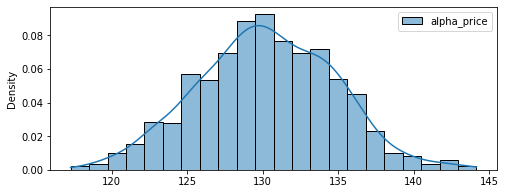

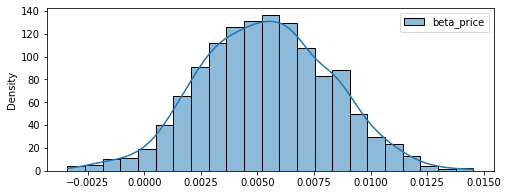

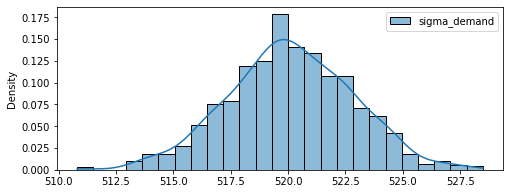

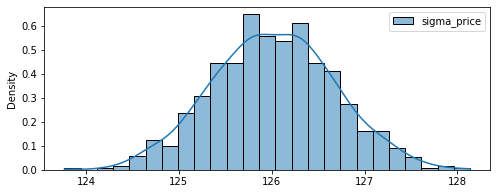

In [ ]:
hmc_samples = {k: v for k, v in mcmc.get_samples().items()}
nodes = [
"alpha_price",
#"beta_demand",
#"beta_demand",
#"beta_demand[2]",
#"beta_demand[3]",'
    "beta_price",
  "sigma_demand",
   "sigma_price" 
]



for node in nodes:
  plt.figure(figsize=(8,3))
  sns.histplot(hmc_samples[node], label=node, kde=True, stat="density")
  plt.legend()
  plt.show()

In [ ]:
q = hmc_samples["y_pred"]
q_mean = q.mean(axis=0).reshape(-1,)
q_std = q.std(axis=0).reshape(-1,)
y_pred_025 = q_mean - 1.96*q_std
y_pred_975 = q_mean + 1.96*q_std
y_pred_mean = q_mean
plt.plot(ix_train[-20:], y_train[-20:, 0], "b-")
plt.plot(ix_test, y_test[:, 0], "bx")
plt.plot(ix_test, y_pred_mean, "r-")
plt.plot(ix_test, y_pred_025, "r--")
plt.plot(ix_test, y_pred_975, "r--")
plt.fill_between(ix_test, y_pred_025, y_pred_975, alpha=0.3)
plt.legend(["true (train)","true (test)","forecast","forecast + stddev","forecast - stddev"])
plt.show()